### U-net

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


In [ ]:
# x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
# w = torch.tensor([0.1, 0.2, 0.3], requires_grad=True)
# y = x * w
# loss = y.sum()
# loss.backward()
# print(w.grad)
# print(x.grad)

In [ ]:
# _x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
# w = torch.tensor([0.1, 0.2, 0.3], requires_grad=True)
# _y = _x * w
# _loss = _y.sum()
# _loss.backward()
# print(w.grad)
# print(_x.grad)

### Util codes

In [2]:
def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch
def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy()
    return x_np
class SinPositionEmbeddingsClass(nn.Module):
    def __init__(self,dim=128,T=1000):
        super().__init__()
        self.dim = dim
        self.T = T
    @torch.no_grad()
    def forward(self,steps=torch.arange(start=0,end=1000,step=1)):
        device = steps.device
        half_dim = self.dim // 2
        # step1
        embeddings = np.log(self.T) / (half_dim - 1)
        # step2
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        # step3
        embeddings = steps[:, None] * embeddings[None, :]
        # step4
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
print ("Ready.")

Ready.


In [36]:
dim=128
T=1000
steps = torch.arange(0,1000,step=1)
print(steps.shape)
half_dim = dim/2
# step1
embeddings = np.log(T) / (half_dim - 1)
print(f"embeddings : {embeddings}")
print(f"embeddings.shape : {embeddings.shape}")

torch.Size([1000])
embeddings : 0.10964690919019265
embeddings.shape : ()


In [37]:
print(embeddings)
# step2
embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
print(embeddings)
print(embeddings.shape)

0.10964690919019265
tensor([1.0000e+00, 8.9615e-01, 8.0309e-01, 7.1969e-01, 6.4495e-01, 5.7797e-01,
        5.1795e-01, 4.6416e-01, 4.1596e-01, 3.7276e-01, 3.3405e-01, 2.9936e-01,
        2.6827e-01, 2.4041e-01, 2.1544e-01, 1.9307e-01, 1.7302e-01, 1.5505e-01,
        1.3895e-01, 1.2452e-01, 1.1159e-01, 1.0000e-01, 8.9615e-02, 8.0309e-02,
        7.1969e-02, 6.4495e-02, 5.7797e-02, 5.1795e-02, 4.6416e-02, 4.1596e-02,
        3.7276e-02, 3.3405e-02, 2.9936e-02, 2.6827e-02, 2.4041e-02, 2.1544e-02,
        1.9307e-02, 1.7302e-02, 1.5505e-02, 1.3895e-02, 1.2452e-02, 1.1159e-02,
        1.0000e-02, 8.9615e-03, 8.0309e-03, 7.1969e-03, 6.4495e-03, 5.7797e-03,
        5.1795e-03, 4.6416e-03, 4.1596e-03, 3.7276e-03, 3.3405e-03, 2.9936e-03,
        2.6827e-03, 2.4041e-03, 2.1544e-03, 1.9307e-03, 1.7302e-03, 1.5505e-03,
        1.3895e-03, 1.2452e-03, 1.1159e-03, 1.0000e-03])
torch.Size([64])


In [38]:
steps[:5, None] , embeddings[:5,None]

(tensor([[0],
         [1],
         [2],
         [3],
         [4]]),
 tensor([[1.0000],
         [0.8962],
         [0.8031],
         [0.7197],
         [0.6449]]))

In [39]:
steps[:, None].shape , embeddings[:,None].shape

(torch.Size([1000, 1]), torch.Size([64, 1]))

In [40]:
# step3
embeddings = steps[:, None] * embeddings[None, :]

In [41]:
embeddings

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 8.9615e-01, 8.0309e-01,  ..., 1.2452e-03, 1.1159e-03,
         1.0000e-03],
        [2.0000e+00, 1.7923e+00, 1.6062e+00,  ..., 2.4904e-03, 2.2318e-03,
         2.0000e-03],
        ...,
        [9.9700e+02, 8.9346e+02, 8.0068e+02,  ..., 1.2415e+00, 1.1125e+00,
         9.9700e-01],
        [9.9800e+02, 8.9436e+02, 8.0148e+02,  ..., 1.2427e+00, 1.1137e+00,
         9.9800e-01],
        [9.9900e+02, 8.9525e+02, 8.0228e+02,  ..., 1.2440e+00, 1.1148e+00,
         9.9900e-01]])

In [42]:
embeddings.shape

torch.Size([1000, 64])

In [43]:
embeddings.sin(), embeddings.cos()

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8415,  0.7809,  0.7195,  ...,  0.0012,  0.0011,  0.0010],
         [ 0.9093,  0.9756,  0.9994,  ...,  0.0025,  0.0022,  0.0020],
         ...,
         [-0.8980,  0.9489,  0.4165,  ...,  0.9463,  0.8968,  0.8398],
         [-0.8555,  0.8391, -0.3648,  ...,  0.9467,  0.8973,  0.8404],
         [-0.0265,  0.0993, -0.9233,  ...,  0.9471,  0.8978,  0.8409]]),
 tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.5403,  0.6246,  0.6945,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4161, -0.2197, -0.0354,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.4401,  0.3155, -0.9091,  ...,  0.3234,  0.4424,  0.5428],
         [ 0.5178, -0.5439, -0.9311,  ...,  0.3222,  0.4414,  0.5420],
         [ 0.9996, -0.9951, -0.3841,  ...,  0.3211,  0.4404,  0.5411]]))

In [44]:
# step4
embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
embeddings.shape

torch.Size([1000, 128])

/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-302307513.py:33: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


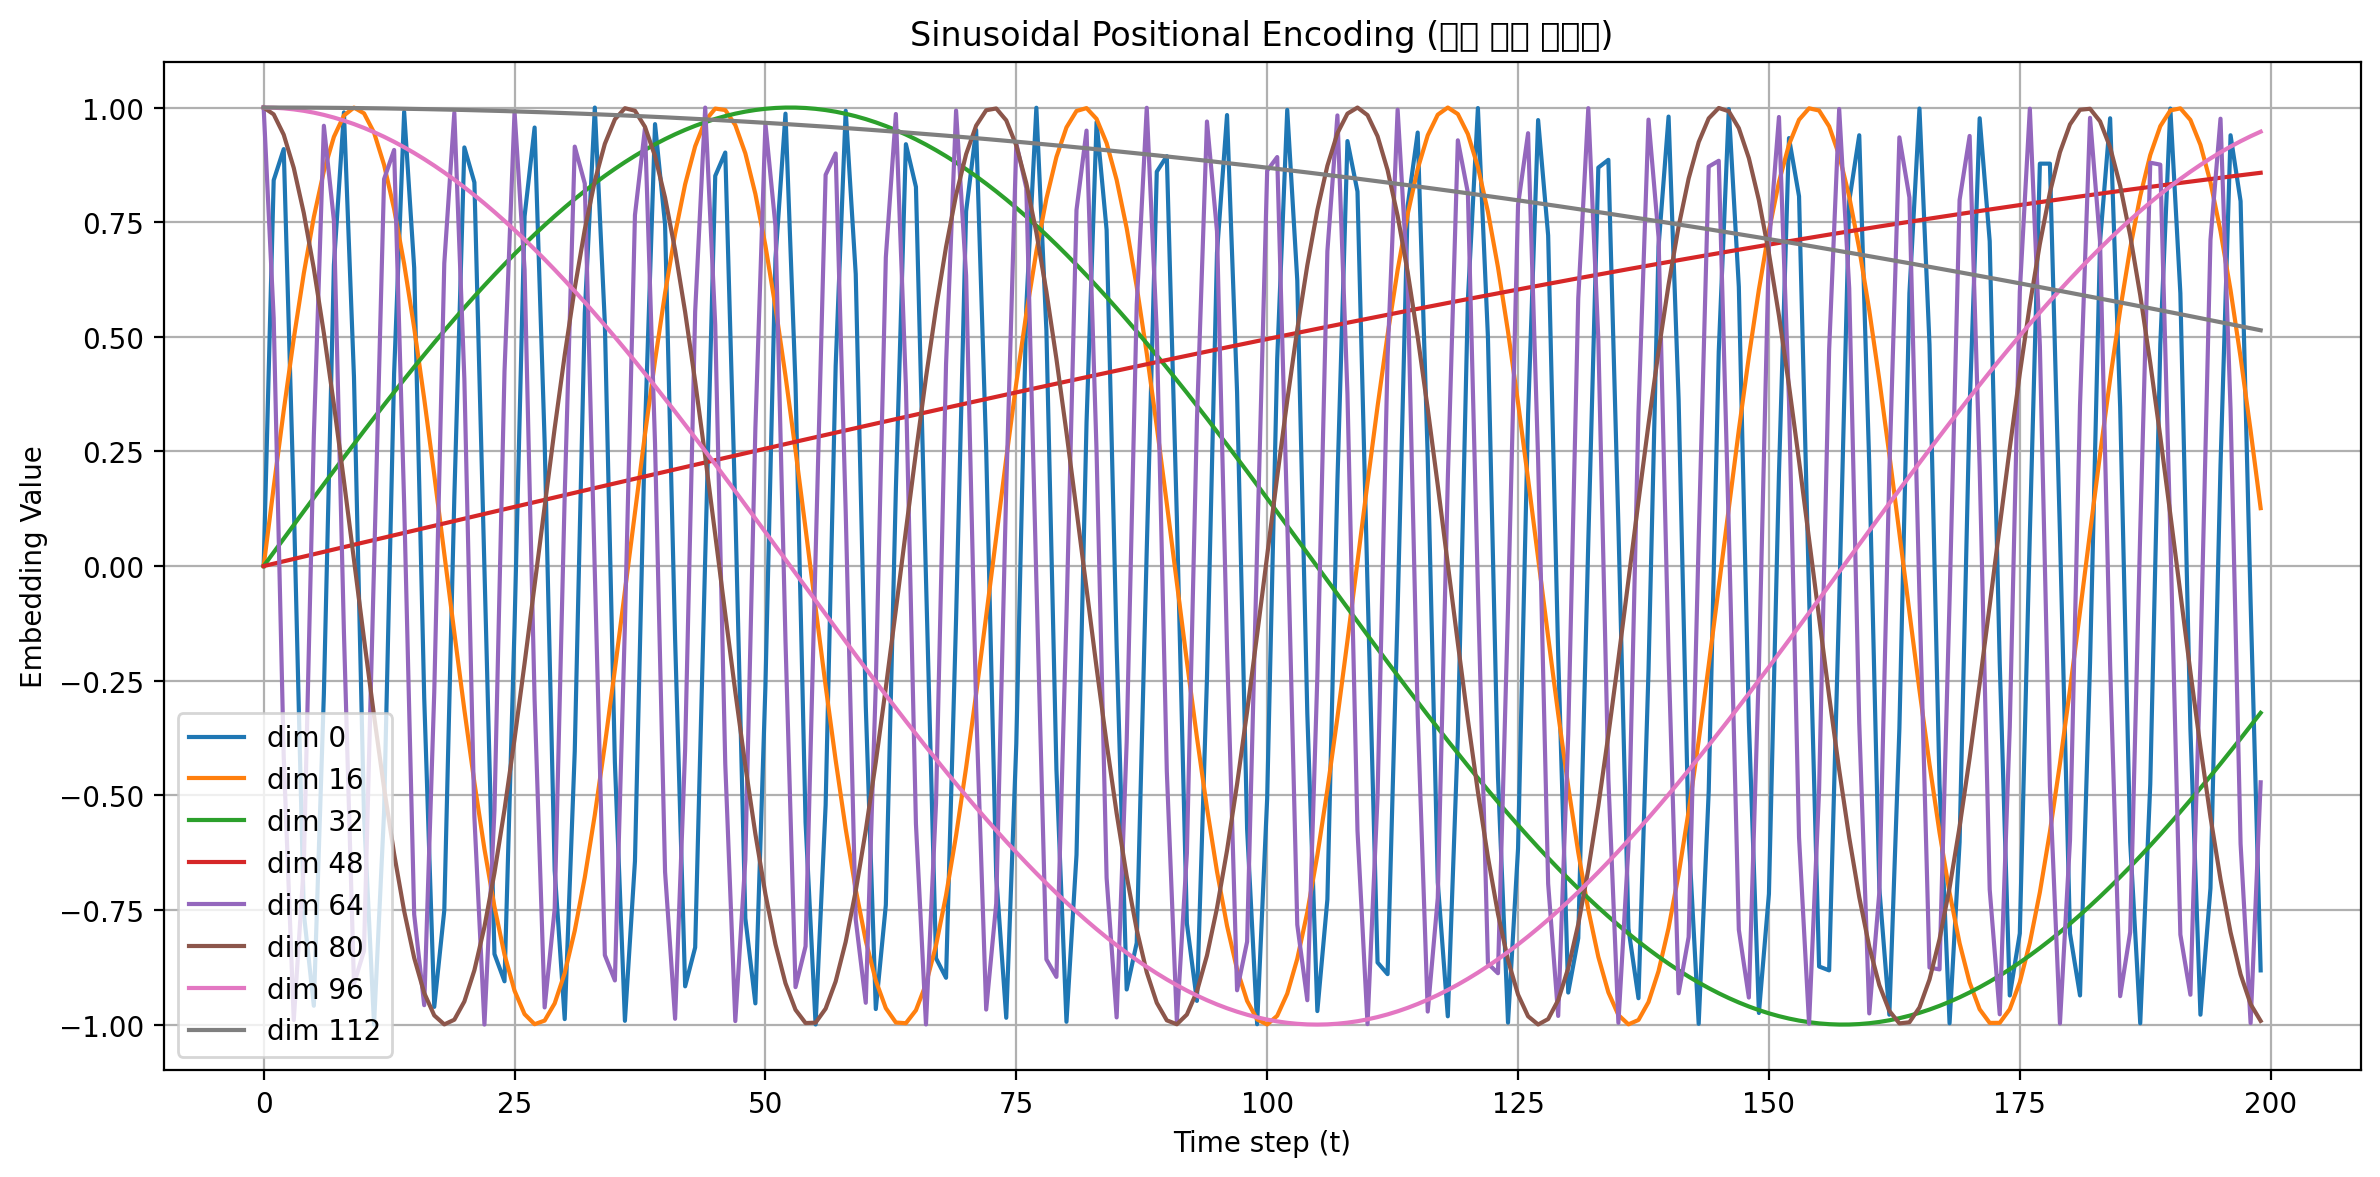

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 설정
dim = 128
T = 1000
steps = torch.arange(0, 200, step=1)  # 적절히 줄인 step 수
half_dim = dim // 2

# Step1: 주파수 스케일 만들기
div_term = np.log(T) / (half_dim - 1)

# Step2: 주파수 벡터 생성
frequencies = torch.exp(torch.arange(half_dim) * -div_term)

# Step3: 각 step에 대해 사인/코사인 입력값 만들기
angles = steps[:, None] * frequencies[None, :]

# Step4: sin + cos 결합
embeddings = torch.cat((angles.sin(), angles.cos()), dim=-1)

# 시각화: 일부 차원만 보기
plt.figure(figsize=(12, 6))
for i in range(0, dim, dim // 8):  # 8개 차원
    plt.plot(steps, embeddings[:, i].numpy(), label=f"dim {i}")

plt.title("Sinusoidal Positional Encoding (부분 차원 시각화)")
plt.xlabel("Time step (t)")
plt.ylabel("Embedding Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
embeddings[:, 0].numpy()

array([ 0.  ,  0.84,  0.91,  0.14, -0.76, -0.96, -0.28,  0.66,  0.99,
        0.41, -0.54, -1.  , -0.54,  0.42,  0.99,  0.65, -0.29, -0.96,
       -0.75,  0.15,  0.91,  0.84, -0.01, -0.85, -0.91, -0.13,  0.76,
        0.96,  0.27, -0.66, -0.99, -0.4 ,  0.55,  1.  ,  0.53, -0.43,
       -0.99, -0.64,  0.3 ,  0.96,  0.75, -0.16, -0.92, -0.83,  0.02,
        0.85,  0.9 ,  0.12, -0.77, -0.95, -0.26,  0.67,  0.99,  0.4 ,
       -0.56, -1.  , -0.52,  0.44,  0.99,  0.64, -0.3 , -0.97, -0.74,
        0.17,  0.92,  0.83, -0.03, -0.86, -0.9 , -0.11,  0.77,  0.95,
        0.25, -0.68, -0.99, -0.39,  0.57,  1.  ,  0.51, -0.44, -0.99,
       -0.63,  0.31,  0.97,  0.73, -0.18, -0.92, -0.82,  0.04,  0.86,
        0.89,  0.11, -0.78, -0.95, -0.25,  0.68,  0.98,  0.38, -0.57,
       -1.  , -0.51,  0.45,  0.99,  0.62, -0.32, -0.97, -0.73,  0.18,
        0.93,  0.82, -0.04, -0.86, -0.89, -0.1 ,  0.78,  0.95,  0.24,
       -0.69, -0.98, -0.37,  0.58,  1.  ,  0.5 , -0.46, -1.  , -0.62,
        0.33,  0.97,

In [46]:
div_term

np.float64(0.10964690919019265)

In [56]:
2*torch.exp(-div_term*torch.tensor([1]))

tensor([1.7923])

In [57]:
frequencies[1]

tensor(0.8962)

In [52]:
angles[2,1]

tensor(1.7923)

In [67]:
angles[2,2]

tensor(1.6062)

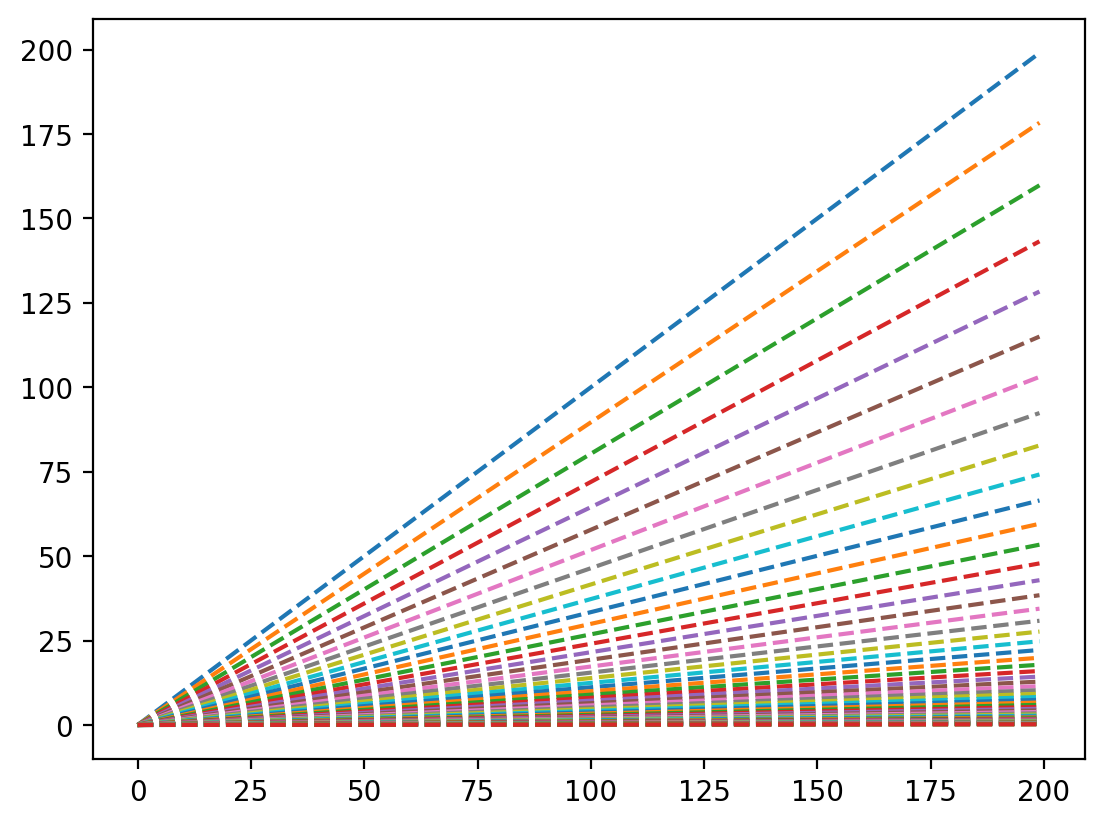

In [59]:
plt.plot(steps,angles,'--')

In [ ]:
class DenseBlockClass(nn.Module):
    def __init__(self,in_dim=10,out_dim=5,pos_emb_dim=10,USE_POS_EMB=True):
        """
            Initialize
        """
        super(DenseBlockClass,self).__init__()
        self.in_dim      = in_dim
        self.out_dim     = out_dim
        self.pos_emb_dim = pos_emb_dim
        self.USE_POS_EMB = USE_POS_EMB

        self.dense1 = nn.Linear(self.in_dim,self.out_dim)
        self.bnorm1 = nn.BatchNorm1d(self.out_dim)
        self.dense2 = nn.Linear(self.out_dim,self.out_dim)
        self.bnorm2 = nn.BatchNorm1d(self.out_dim)
        self.actv   = nn.ReLU()
        self.pos_emb_mlp = nn.Linear(self.pos_emb_dim,self.out_dim)

    def forward(self,x,t):
        """
            Forward
        """
        h = self.bnorm1(self.actv(self.dense1(x))) # dense -> actv -> bnrom1 [B x out_dim]
        if self.USE_POS_EMB:
            h = h + self.pos_emb_mlp(t) # [B x out_dim]
        h = self.bnorm2(self.actv(self.dense2(h))) # [B x out_dim]
        return h

DenseBlock = DenseBlockClass(in_dim=100,out_dim=20,pos_emb_dim=64)
x = torch.randn(128,100)
t = torch.randn(128,64)
out = DenseBlock(x=x,t=t) # forward Block

print ("x:%s,t:%s to out:%s"%(x.shape,t.shape,out.shape))

x:torch.Size([128, 100]),t:torch.Size([128, 64]) to out:torch.Size([128, 20])


### Dense U-Net
<img src="https://github.com/sjchoi86/yet-another-diffusion-models/blob/main/img/DenseUNet.jpeg?raw=1" width="500" />
<img src="https://github.com/sjchoi86/yet-another-diffusion-models/blob/main/img/Block.jpeg?raw=1" width="500" />

In [ ]:
class DenseUNetClass(nn.Module):
    def __init__(self,name='dense_unet',
                 x_dim=300,pos_emb_dim=128,h_dims=[128,64],z_dim=32,
                 USE_POS_EMB=True):
        """
            Initialize
        """
        super(DenseUNetClass,self).__init__()
        self.name        = name
        self.x_dim       = x_dim
        self.pos_emb_dim = pos_emb_dim
        self.h_dims      = h_dims
        self.z_dim       = z_dim
        self.USE_POS_EMB = True
        # Initialize layers
        self.init_layers()

    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()
        # Encoder
        h_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['Enc_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = h_dim
        self.layers['Enc_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=self.h_dims[-1],out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)
        # Map
        self.layers['Map'] = DenseBlockClass(
            in_dim=self.z_dim,out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)
        # Decoder
        h_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['Dec_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = 2*h_dim
        self.layers['Dec_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=h_prev,out_dim=self.x_dim,
            pos_emb_dim=self.pos_emb_dim,USE_POS_EMB = self.USE_POS_EMB)
        # Out
        self.layers['Out'] = DenseBlockClass(
            in_dim=2*self.x_dim,out_dim=self.x_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)

    def forward(self,x,t):
        """
            Forward
        """
        net = x # [B x x_dim]
        # Net
        self.nets = []
        # Encoder
        self.enc_paths = []
        self.enc_paths.append(net)
        self.nets.append(net)
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Enc_%02d'%(h_idx)](net,t)
            self.enc_paths.append(net)
            self.nets.append(net)
        # Map
        net = self.layers['Map'](net,t)
        self.nets.append(net)
        # Decoder
        self.dec_paths = []
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Dec_%02d'%(h_idx)](net,t)
            net = torch.cat([self.enc_paths[len(self.h_dims)-h_idx],net],dim=1)
            self.dec_paths.append(net)
            self.nets.append(net)
        net = self.layers['Out'](net,t)
        self.nets.append(net)
        return net

print ("Ready.")

Ready.


### Demo forward path

In [ ]:
DUNet = DenseUNetClass(x_dim=300,pos_emb_dim=32,h_dims=[128,64],z_dim=32,USE_POS_EMB=True)
x = torch.randn(128,300)
t = torch.randn(128,32)
DUNet(x=x,t=t)
print ("Ready")

Ready


### Print

In [ ]:
print ("Layer information")
for key_idx,key in enumerate(DUNet.layers.keys()):
    layer = DUNet.layers[key]
    print ("[%d/%d][%7s] [%03d] =>[%03d]"%
           (key_idx,len(DUNet.layers.keys()),key,layer.dense1.in_features,layer.dense1.out_features))

print ("Network information")
for net_idx in range(len(DUNet.nets)):
    net = DUNet.nets[net_idx]
    print ("[%02d/%02d] %s"%(net_idx,len(DUNet.nets),net.shape))

Layer information
[0/8][ Enc_00] [300] =>[128]
[1/8][ Enc_01] [128] =>[064]
[2/8][ Enc_02] [064] =>[032]
[3/8][    Map] [032] =>[032]
[4/8][ Dec_00] [032] =>[064]
[5/8][ Dec_01] [128] =>[128]
[6/8][ Dec_02] [256] =>[300]
[7/8][    Out] [600] =>[300]
Network information
[00/09] torch.Size([128, 300])
[01/09] torch.Size([128, 128])
[02/09] torch.Size([128, 64])
[03/09] torch.Size([128, 32])
[04/09] torch.Size([128, 32])
[05/09] torch.Size([128, 128])
[06/09] torch.Size([128, 256])
[07/09] torch.Size([128, 600])
[08/09] torch.Size([128, 300])


### Projecting U-net

In [ ]:
class SinPositionEmbeddingsClass(nn.Module):
    def __init__(self,dim=128,T=1000):
        super().__init__()
        self.dim = dim
        self.T = T
    @torch.no_grad()
    def forward(self,steps=torch.arange(start=0,end=1000,step=1)):
        device = steps.device
        half_dim = self.dim // 2
        embeddings = np.log(self.T) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DenseBlockClass(nn.Module):
    def __init__(self,in_dim=10,out_dim=5,pos_emb_dim=10,USE_POS_EMB=True):
        """
            Initialize dense block network with posisional embedding
        """
        super(DenseBlockClass,self).__init__()
        self.in_dim      = in_dim
        self.out_dim     = out_dim
        self.pos_emb_dim = pos_emb_dim
        self.USE_POS_EMB = USE_POS_EMB
        # Simple block consists of two layers
        self.dense1 = nn.Linear(self.in_dim,self.out_dim)
        self.bnorm1 = nn.BatchNorm1d(self.out_dim)
        self.dense2 = nn.Linear(self.out_dim,self.out_dim)
        self.bnorm2 = nn.BatchNorm1d(self.out_dim)
        self.actv   = nn.ReLU()
        # Positional embedding
        self.pos_emb_mlp = nn.Linear(self.pos_emb_dim,self.out_dim)
    def forward(self,x,t):
        """
            Forward
        """
        h = self.bnorm1(self.actv(self.dense1(x))) # dense -> actv -> bnrom1 [B x out_dim]
        if self.USE_POS_EMB:
            h = h + self.pos_emb_mlp(t) # [B x out_dim]
        h = self.bnorm2(self.actv(self.dense2(h))) # [B x out_dim]
        return h

class DenoisingDenseUnetClass(nn.Module):
    def __init__(self,
                 name        = 'denoising_dense_unet',
                 D           = 3,
                 L           = 100,
                 T           = 1000, # max diffusion steps
                 pos_emb_dim = 127,
                 h_dims      = [128,64],
                 z_dim       = 32,
                 USE_POS_EMB = True,
                 Gammas      = None
                ):
        """
            Initialize denoising dense unet for DDPM
            The input dimension would be L*D
        """
        super(DenoisingDenseUnetClass,self).__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.T           = T
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.h_dims      = h_dims
        self.z_dim       = z_dim
        self.USE_POS_EMB = USE_POS_EMB
        self.Gammas      = Gammas # RKHS projections
        # Initialize layers
        self.init_layers()

    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()
        # Encoder (x->z)
        h_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['Enc_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = h_dim
        self.layers['Enc_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=self.h_dims[-1],out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)
        # Map (z->z)
        self.layers['Map'] = DenseBlockClass(
            in_dim=self.z_dim,out_dim=self.z_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)
        # Decoder (z->x)
        h_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['Dec_%02d'%(h_idx)] = DenseBlockClass(
                in_dim=h_prev,out_dim=h_dim,pos_emb_dim=self.pos_emb_dim,
                USE_POS_EMB = self.USE_POS_EMB)
            h_prev = 2*h_dim
        self.layers['Dec_%02d'%(len(self.h_dims))] = DenseBlockClass(
            in_dim=h_prev,out_dim=self.x_dim,
            pos_emb_dim=self.pos_emb_dim,USE_POS_EMB = self.USE_POS_EMB)
        # Out
        self.layers['Out'] = DenseBlockClass(
            in_dim=2*self.x_dim,out_dim=self.x_dim,pos_emb_dim=self.pos_emb_dim,
            USE_POS_EMB = self.USE_POS_EMB)
        # Time embedding
        self.layers['Pos_Emb'] = nn.Sequential(
                SinPositionEmbeddingsClass(dim=self.pos_emb_dim,T=self.T),
                nn.Linear(self.pos_emb_dim,self.pos_emb_dim),
                nn.GELU()
            )
    def forward(self,x,t):
        """
            Forward
            x: [B x x_dim]
            t: [B x 1]
        """
        net = x # [B x x_dim]
        # Positional Embedding
        pos_emb = self.layers['Pos_Emb'](t) # [B x pos_emb_dim]
        # Net
        self.nets = {}
        # Encoder
        self.enc_paths = []
        self.enc_paths.append(net)
        self.nets['x'] = net
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Enc_%02d'%(h_idx)](net,pos_emb)
            self.enc_paths.append(net)
            self.nets['Enc_%02d'%(h_idx)] = net
        # Map
        net = self.layers['Map'](net,pos_emb) # [B x z_dim]
        self.nets['Map'] = net # [B x z_dim]
        # Decoder
        self.dec_paths = []
        for h_idx in range(len(self.h_dims)+1):
            net = self.layers['Dec_%02d'%(h_idx)](net,pos_emb)
            net = torch.cat([self.enc_paths[len(self.h_dims)-h_idx],net],dim=1)
            self.dec_paths.append(net)
            self.nets['Dec_%02d'%(h_idx)] = net
        net = self.layers['Out'](net,pos_emb) # [B x LD]

        # RKHS projection
        self.Gammas # [D x L x L]


        # Return
        self.nets['Out'] = net  # [B x LD]
        return net

print ("Ready.")

Ready.


### Model usage

In [ ]:
from scipy.spatial import distance
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
def get_gamma(times=np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)), # [L x 1]
              hyp_len=1.0,reg_coef=1e-8):
    """
        RKHS projection
    """
    L = times.shape[0]
    K = kernel_se(times,times,hyp={'gain':1.0,'len':hyp_len}) # [L x L]
    Gamma = K @ np.linalg.inv(K + reg_coef*np.eye(L,L)) # [L x L]
    return Gamma
print ("Ready.")

Ready.


In [ ]:
# Hyper parameters
D,L,T = 3,100,1000
times = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)) # [L x 1]
Gammas_np = np.zeros(shape=(D,L,L))
hyp_lens = [1,0.1,0.01]
for d_idx in range(D):
    hyp_len = hyp_lens[d_idx]
    Gammas_np[d_idx,:,:] = get_gamma(times=times,hyp_len=hyp_len,reg_coef=1e-6) # [L x L]
Gammas = np2torch(Gammas_np) # [D x L x L]
# Instantiate denoising dense U-net class
model = DenoisingDenseUnetClass(
    L=L,D=D,T=T,pos_emb_dim=16,h_dims=[64],z_dim=32,USE_POS_EMB=True,Gammas=Gammas)
# Forward path
B = 5 # batch size
x = torch.randn(B,D*L) # [B x LD]
steps = torch.zeros(B).type(torch.long) # [B]
out = model(x=x,t=steps) # [B x DL]
# Print-out forward path
for key_idx,key in enumerate(model.nets.keys()):
    net = model.nets[key]
    print ("[%02d] [%8s]: %s"%(key_idx,key,net.shape))
print ("Done.")

[00] [       x]: torch.Size([5, 300])
[01] [  Enc_00]: torch.Size([5, 64])
[02] [  Enc_01]: torch.Size([5, 32])
[03] [     Map]: torch.Size([5, 32])
[04] [  Dec_00]: torch.Size([5, 128])
[05] [  Dec_01]: torch.Size([5, 600])
[06] [     Out]: torch.Size([5, 300])
Done.
